
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)
## Vehicle Detection & Tracking Pipeline

In this project, your goal is to write a software pipeline to detect vehicles in a video (start with the test_video.mp4 and later implement on full project_video.mp4), but the main output or product we want you to create is a detailed writeup of the project.  Check out the [writeup template](https://github.com/udacity/CarND-Vehicle-Detection/blob/master/writeup_template.md) for this project and use it as a starting point for creating your own writeup.  

The Project
---

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

Here are links to the labeled data for [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) examples to train your classifier.  These example images come from a combination of the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself.   You are welcome and encouraged to take advantage of the recently released [Udacity labeled dataset](https://github.com/udacity/self-driving-car/tree/master/annotations) to augment your training data.  

Some example images for testing your pipeline on single frames are located in the `test_images` folder.  To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `ouput_images`, and include them in your writeup for the project by describing what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

### Dataset - Load Data and Extract Features

In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from PIL import Image
import time
import os
import pickle
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
## Dataset Parameters ##
LABELS_CSV = 'FILL_LATER.csv'
TRAINING_DATASET_DIRECTORY = 'training_set/'
PIPELINE_SETUP_DIRECTORY = 'pipeline_setup_images/'
WORKING_DIRECTORY = 'data/'
NON_VEHICLES_TOKEN = 'non-vehicles'
dataset_path = "{}{}{}{}".format(WORKING_DIRECTORY, TRAINING_DATASET_DIRECTORY,'**/', '*.png')
DATACACHE_DIRECTORY = os.path.join(WORKING_DIRECTORY, 'datacache/')

## Image Processing ##
DEFAULT_LENGTH, DEFAULT_WIDTH, DEFAULT_DEPTH = (64, 64, 3)
if DEFAULT_DEPTH > 1:
    DEFAULT_RESOLUTION = (DEFAULT_LENGTH, DEFAULT_WIDTH, DEFAULT_DEPTH)
else:
    DEFAULT_RESOLUTION = (DEFAULT_LENGTH, DEFAULT_WIDTH)

## Feature Extraction Parameters ##
# Spatial Binning
SPATIAL = 20
BIN_SPATIAL_SIZE = (SPATIAL, SPATIAL)
# Color Histogram
HIST_NBINS = 128
HIST_BINS_RANGE = (0, 256)
COLOR_SPACE = 'YUV'
# HOG Parameters
HOG_COLOR_SPACE = 'HSV'
HOG_ORIENTATIONS = 9
HOG_PIXELS_PER_CELL = 8
HOG_CELLS_PER_BLOCK = 2
HOG_CHANNEL = 'ALL' # Can be 0, 1, 2, or "ALL"

# SVC Parameters
VALIDATION_PORTION = .3
N_PREDICTIONS = 100

In [3]:
# Define a function to scale .PNG and JPEG Files both to 0 to 1 
def normalize_pixels(img):
    max_pixel_value = np.max(img)
    if max_pixel_value > 1.0:
        img = np.copy(np.multiply(img, 1.0 / 255.0)).astype(np.float64) 
    return img

# Define a function to scale .PNG and JPEG Files both to 0 to 1 
def denormalize_pixels(img):
    max_pixel_value = np.max(img)
    if max_pixel_value <= 1.0:
        img = np.copy(np.multiply(img, 255.0)).astype(np.float64) 
    return img

# PNG Files sometimes have an alpha channel (RGBA), convert to RGB in such cases
def rgba_to_rgb(filepaths):
    for current_img in filepaths:
        if os.path.exists(current_img):
            img = Image.open(current_img)
            if img.mode == 'RGBA':
                img = img.convert(COLOR_SPACE)
                img.save(current_img)
            img.close()

In [4]:
# Define a function to compute binned color features  
def bin_spatial(img, size=BIN_SPATIAL_SIZE):
    denormalized_img = denormalize_pixels(img)
    # Scale down and ravel image  
    features = cv2.resize(denormalized_img, size).ravel() 
    return features

In [5]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=HIST_NBINS, bins_range=HIST_BINS_RANGE):
    denormalized_img = denormalize_pixels(img)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(denormalized_img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(denormalized_img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(denormalized_img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


In [6]:
# Define a function to return HOG features and visualization
def get_hog_features(img, hog_cspace=HOG_COLOR_SPACE, orient=HOG_ORIENTATIONS, pix_per_cell=HOG_PIXELS_PER_CELL,
                     cell_per_block=HOG_CELLS_PER_BLOCK, hog_channel=HOG_CHANNEL, vis=False, feature_vec=True):      
    denormalized_img = denormalize_pixels(img)
    if vis == True:
        features, hog_image = hog(denormalized_img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(denormalized_img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

In [7]:
# Define a function to extract features from a list of images
def extract_features(imgs, cspace=COLOR_SPACE, spatial_size=BIN_SPATIAL_SIZE,
                        hist_bins=HIST_NBINS, hist_range=HIST_BINS_RANGE):
    # Create a list to append feature vectors
    features = []
    for file in imgs:
        image = mpimg.imread(file)

        # Image read in from mpimg + .png -> (0 to 1) scaled
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        # Call get_hog_features() with vis=False, feature_vec=True
        hog_image = np.copy(image)
        hog_shape = np.asarray(hog_image.shape)
        if HOG_CHANNEL == 'ALL':
            hog_features = []
            for channel in range(len(hog_shape)):
                hog_features.append(get_hog_features(hog_image[:,:,channel]))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(hog_image[:,:,HOG_CHANNEL])
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

In [8]:
## Starting Training Pipeline ##
# Load Image Paths 
images = glob.glob(dataset_path, recursive=True)
print('Found',len(images),'images in directory:', dataset_path)

#Convert RGBA to RGB for PNG files
rgba_to_rgb(images)

cars = []
notcars = []
for image in images:
    if NON_VEHICLES_TOKEN in image:
        notcars.append(image)
    else:
        cars.append(image)
assert len(images) == len(cars) + len(notcars), 'The subarrays have not split the dataset correctly.'

Found 17760 images in directory: data/training_set/**/*.png


Feature Vector size for Cars: 6876
Using Spatial Binning of: 20 and 128 histogram bins


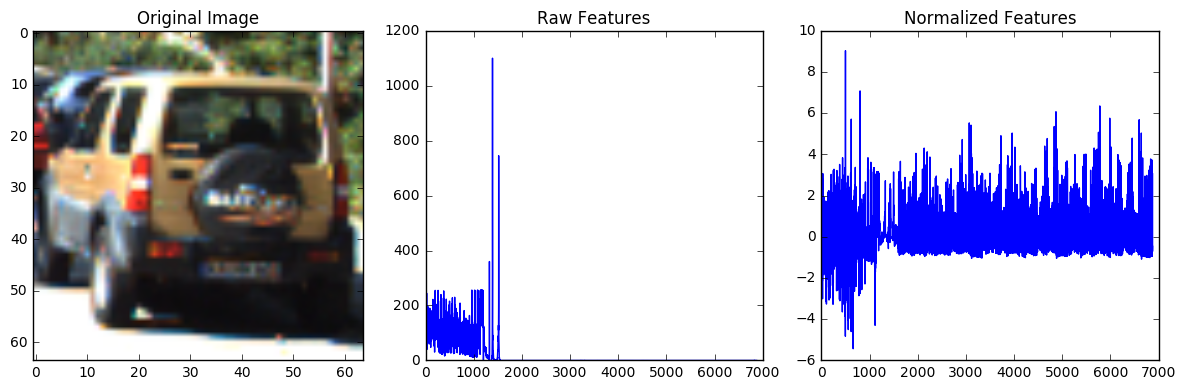

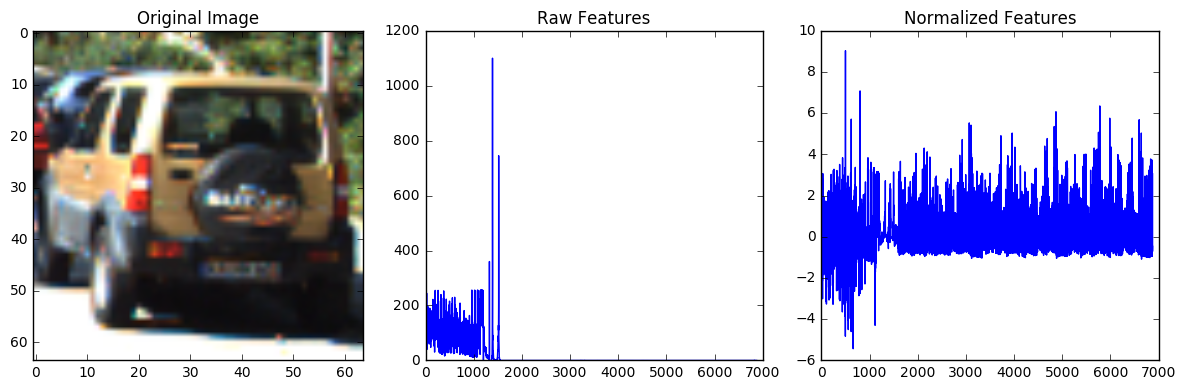

In [9]:
# Start Pipeline - Combine and Normalilze Features
car_features = extract_features(cars)
notcar_features = extract_features(notcars)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)
car_ind = np.random.randint(0, len(cars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

print('Feature Vector size for Cars:', len(car_features[car_ind]))
print('Using Spatial Binning of:',BIN_SPATIAL_SIZE[0],
    'and', HIST_NBINS,'histogram bins')
fig

In [10]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [11]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=VALIDATION_PORTION, random_state=rand_state)
print('Feature vector length:', len(X_train[0]))

Feature vector length: 6876


In [12]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = N_PREDICTIONS
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

32.21 Seconds to train SVC...
Test Accuracy of SVC =  0.9901
My SVC predicts:  [ 1.  0.  0.  1.  0.  1.  1.  0.  0.  1.  1.  0.  0.  0.  1.  0.  1.  1.
  0.  1.  1.  0.  1.  0.  1.  1.  1.  1.  1.  0.  1.  0.  1.  1.  1.  1.
  1.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.
  1.  0.  1.  1.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  1.  1.
  1.  1.  1.  0.  0.  1.  0.  1.  1.  0.  1.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  1.  0.  1.  1.  1.  1.  1.]
For these 100 labels:  [ 1.  0.  0.  1.  0.  1.  1.  0.  0.  1.  1.  0.  0.  0.  1.  0.  1.  1.
  1.  1.  1.  0.  1.  0.  1.  1.  1.  1.  1.  0.  1.  0.  1.  1.  1.  1.
  1.  0.  0.  0.  0.  0.  1.  0.  0.  1.  1.  0.  1.  0.  1.  0.  1.  0.
  1.  0.  1.  1.  1.  1.  0.  0.  0.  0.  1.  1.  0.  0.  1.  0.  1.  1.
  1.  1.  1.  0.  0.  1.  0.  1.  1.  0.  1.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  1.  0.  1.  1.  1.  1.  1.]
0.01803 Seconds to predict 100 labels with SVC


In [13]:
#Save Support Vector Classifier to Datacache
def save_to_datacache(support_vector_classifier, datacache_dir=DATACACHE_DIRECTORY):
    os.makedirs(datacache_dir, exist_ok=True)
    svc_pickle = os.path.join(datacache_dir,"svc_pickle.p")
    if not os.path.exists(svc_pickle): 
        svc_hyperparameters = {'svc': svc,
                               'X_scaler':X_scaler,
                               'SPATIAL': SPATIAL, 
                               'HIST_NBINS': HIST_NBINS,
                               'HIST_BINS_RANGE_MIN': HIST_BINS_RANGE[0],
                               'HIST_BINS_RANGE_MAX': HIST_BINS_RANGE[1],
                               'COLOR_SPACE': COLOR_SPACE,
                               'HOG_ORIENTATIONS': HOG_ORIENTATIONS,
                               'HOG_PIXELS_PER_CELL': HOG_PIXELS_PER_CELL,
                               'HOG_CELLS_PER_BLOCK': HOG_CELLS_PER_BLOCK,
                               'HOG_CHANNEL': HOG_CHANNEL
                              }

        pickle.dump(svc_hyperparameters, open(svc_pickle, "wb"))
    
# Save classifier and parameters to datacache directory  
save_to_datacache(svc)

# Finished Training SVC - Now to Utilize Sliding Windows

In [14]:
# Sliding Window Constants
WORKING_DIRECTORY = 'data/'
DATACACHE_DIRECTORY = os.path.join(WORKING_DIRECTORY, 'datacache/')
svc_pickle = os.path.join(DATACACHE_DIRECTORY,"svc_pickle.p")
TESTING_DATASET_DIRECTORY = 'testing_dataset/'
TESTING_PIPELINE_SETUP_DIR= 'test_images/'

testset_path = "{}{}{}".format(WORKING_DIRECTORY, TESTING_PIPELINE_SETUP_DIR, '*.jpg')


with open(svc_pickle, mode='rb') as f:
    svc_hyperparameters = pickle.load(f)
    
    
## Feature Extraction Parameters ##
# Spatial Binning
SVC = svc_hyperparameters['svc']
X_SCALER = svc_hyperparameters['X_scaler']
SPATIAL = svc_hyperparameters['SPATIAL']

BIN_SPATIAL_SIZE = (SPATIAL, SPATIAL)
# Color Histogram
HIST_NBINS = svc_hyperparameters['HIST_NBINS']
HIST_BINS_RANGE = (svc_hyperparameters['HIST_BINS_RANGE_MIN'], svc_hyperparameters['HIST_BINS_RANGE_MAX'])
COLOR_SPACE = svc_hyperparameters['COLOR_SPACE']
# HOG Parameters
HOG_ORIENTATIONS = svc_hyperparameters['HOG_ORIENTATIONS']
HOG_PIXELS_PER_CELL = svc_hyperparameters['HOG_PIXELS_PER_CELL']
HOG_CELLS_PER_BLOCK = svc_hyperparameters['HOG_CELLS_PER_BLOCK']
HOG_CHANNEL = svc_hyperparameters['HOG_CHANNEL'] # Can be 0, 1, 2, or "ALL"

## Verify SVC loaded ##
print('svc', SVC)
print('X_scaler', X_SCALER)

## Sliding Windows Parameters ##
BBOX_COLOR = (0, 0, 255)
BBOX_THICK = 6

SW_CONVERT_COLOR = 'RGB2YCrCb'
SW_YSTART = 400
SW_YSTOP = 656
SW_SCALE = 1.75 

svc LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
X_scaler StandardScaler(copy=True, with_mean=True, with_std=True)


In [26]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=BBOX_COLOR, thick=BBOX_THICK):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [27]:
def convert_color(img, conv=SW_CONVERT_COLOR):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [28]:
def get_hog_features(img, orient=HOG_ORIENTATIONS, pix_per_cell=HOG_PIXELS_PER_CELL, 
                     cell_per_block=HOG_CELLS_PER_BLOCK, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [29]:
def bin_spatial(img, size=BIN_SPATIAL_SIZE):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    spatial_feats = np.hstack((color1, color2, color3))
    return spatial_feats

In [30]:
def color_hist(img, nbins=HIST_NBINS):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features


In [31]:
# Try Scaling Windows on Test Images

image_paths = glob.glob(testset_path, recursive=True)
print('Found',len(images),'images in directory:', testset_path)

img_path = image_paths[0]

Found 17760 images in directory: data/test_images/*.jpg


In [34]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img_path, ystart=SW_YSTART, ystop=SW_YSTOP, scale=SW_SCALE, svc=SVC, X_scaler=X_SCALER,
              orient=HOG_ORIENTATIONS, pix_per_cell=HOG_PIXELS_PER_CELL, cell_per_block=HOG_CELLS_PER_BLOCK,
              spatial_size=BIN_SPATIAL_SIZE, hist_bins=HIST_NBINS):
    
    img = mpimg.imread(img_path)
    draw_img = np.copy(img)
    
    img = normalize_pixels(img).astype(np.float32)
    #print(img)
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    window = HOG_PIXELS_PER_CELL*HOG_PIXELS_PER_CELL # 8 cells and 8 pix per cell
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

            
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg)
            hist_features = color_hist(subimg)
            
            # Extract HOG for the entire region of interst instead of for the particular patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            test_feats = np.hstack((spatial_features, hist_features, hog_features))
            # Scale features and make a prediction
            test_features = X_scaler.transform(test_feats.reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

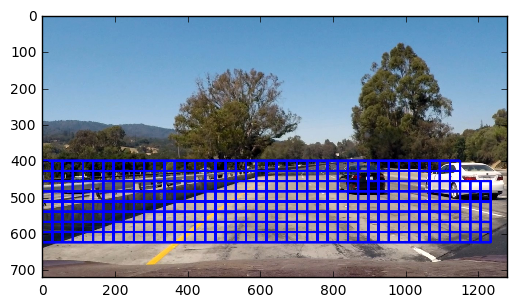

In [35]:
out_img = find_cars(img_path)
plt.imshow(out_img)